# EE 120 Lab 3: The Fast Fourier Transform (FFT)

v1 (Demo) - Fall 2018: Dominic Carrano  
v2 - Spring 2019: Dominic Carrano, Babak Ayazifar  
v3 - Fall 2019: Dominic Carrano

In [1]:
import time
import timeit

import lab3_helper
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

%matplotlib inline

# Background

## What is the FFT?

In this lab, we'll implement the Fast Fourier Transform (FFT), an algorithm that computes the Discrete Fourier Transform (DFT) of a signal. Note that the DFT and FFT are *not* separate transforms: the FFT is just a specific algorithm for implementing the DFT, in the same way that quicksort is a specific algorithm for sorting an array. And, chances are, you've called a library function to sort an array before in Java or Python. But have you ever bothered to peruse the [source code for Java's Arrays.sort](http://developer.classpath.org/doc/java/util/Arrays-source.html) or for [Python's list sorting function](https://github.com/python/cpython/blob/master/Objects/listobject.c)? Probably not. And the beauty of well-designed abstractions is that you've never needed to - you can just call Arrays.sort (in Java) or `sort` (in Python) and everything's handled for you. Similarly, in practice, engineers don't care about the internals of `numpy.fft.fft` (numpy's function for computing the DFT), they just treat it as a black box for computing the DFT. However, in this lab, you'll get a chance to take a look inside the box, build your own, and compare it against the state of the art! This is well worth the effort given how widely used the FFT is in practical spectral analysis and as a building block for efficiently implementing dozens of other signal processing algorithms such as convolution, cross-correlation, image and audio compression, and more!

## Why is being able to compute the DFT efficiently so important?

Before diving in, you may be curious about the motivation for the FFT. If all it does is compute the DFT, why is it so important? Is directly using the analysis equation really that slow? And why would we even need to compute the DFT? These are two great questions that each deserve an answer.

### Importance of the DFT

You've already seen why the Fourier Transform is a major player in Signals and Systems: it enables us to decompose a signal into its constituent frequencies, enabling a much cleaner analysis of how LTI systems operate. However, computing the spectrum (i.e., Fourier Transform) of an arbitrary signal with pencil and paper ranges from tedious to intractable. Indeed, computers are much better suited than humans for tasks like this. As great as computers are, however, they have some limitations. In particular, computers have finite memory, so doing anything with CT signals directly is out of the question, since they contain infinitely many values. Fortunately, given certain conditions, we can sample a CT signal to obtain a DT one without any loss of information (we'll see how later in the class), and only need to consider the case of DT signals. In fact, all signals of interest in practice are finite-duration, or can be truncated to a finite number of data points without any major loss of information. For example, an audio file only contains a finite number of samples determined by the song length. Thus, we only need consider *finite-duration* DT signals, which we *can* store on a computer!

Now, suppose we've acquired our finite-duration DT signal and have it stored in a numpy array, and we want to see what frequencies it's composed of. Naturally, it seems like we'd want to compute its DTFT. But the DTFT is a continuous function of frequency (unlike the CTFT, it's $2\pi$ periodic, but there are still infinitely many values in a single period), so we again run into the problem of being unable to store all of it. This is where the DFT shines: **the DFT of a duration $N$ signal returns $N$ uniformly-spaced samples of its DTFT.** To see why, let's compare the DFT and DTFT analysis equations side by side:

$$\underbrace{X[k] = \sum_{n = 0}^{N - 1} x[n]e^{-j\frac{2\pi}{N}kn}}_{\text{DFT Analysis}}\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \underbrace{X(e^{j\omega}) = \sum_{n = -\infty}^{\infty} x[n]e^{-j\omega n}}_{\text{DTFT Analysis}}$$

If we assume our signal has exactly $N$ nonzero points (i.e., its duration is $N$), the range of the DTFT analysis equation matches that of the DFT. Additionally, if we evaluate the DTFT equation at the $N$ equally spaced points $\omega = 0, \frac{2\pi}{N}, \frac{2\pi \cdot 2}{N}, ..., \frac{2\pi \cdot (N-1)}{N}$, we get the values $X[0], X[1], X[2], ..., X[N-1]$ given by the DFT analysis equation! **This is why the DFT is so important: it's the only method we have to compute a signal's spectrum on a computer.** It's not obvious that these $N$ samples of a DTFT are enough to faithfully represent it. In practice zero-padding a signal with its implicit zeros will increase $N$, the length of the signal, and thus the number of samples of the DTFT you take, giving a better approximation of it. Indeed, this is one of the first things covered in EE 123: if you're plotting a signal's spectrum and need better resolution, you can just zero pad it!

See the Lecture 10 notes for a more formal derivation of the connection between the DFT and DTFT.

### How fast is "fast enough"?

Now that we've discussed the importance of the DFT in depth, you may wonder why the analysis equation alone is too slow for computing the DFT. In practice, $N$, the duration of the signal, is typically *at least* in the hundreds, and more commonly on the order of 1000 or 10000, and can be even larger depending on the application. The DFT analysis equation takes on the order of $N^2$ computations (you'll explore why later). On the other hand, the FFT takes on the order of $N \log N$ computations, which is much faster (in fact, as $N$ approaches $\infty$, it becomes infinitely faster). You'll soon see how much of a difference this makes when you have to wait for your naive DFT function to run, in case you're currently unconvinced :)

# Q1: Naive DFT

## Q1a: DFT Code

We'll begin by implementing the DFT the "naive" way by simply translating the DFT analysis equation into code. 

If we have a signal of duration $N$ (in a computer, a numpy array of length $N$), the DFT analysis equation is:

$$X[k] = \sum_{n = 0}^{N-1} x[n] e^{-j\frac{2\pi}{N}nk}$$

for $k, n \in \{0, 1, 2, ..., N - 1\}$. In general, $X[k]$ is a complex-valued array, even if $x[n]$ is purely real, which we must account for when writing our code by declaring our output type as `np.complex128` (a pair of floating-point "real" numbers, each 64 bits, for a total of 128 bits). If we don't, numpy will throw out the imaginary part when doing our computations, and return the incorrect result.

Fill in the function `dft` below to compute the DFT based on the analysis equation. In your array `X` that you output, `X[k], k = 0, 1, ..., N-1` should be the value of the `k`th DFT coefficient.

**Hint 1:** The function call `np.exp(z)` returns $e^z$, where $z$ is any number, real or complex. You've used this function before, but only on real numbers or arrays of real numbers. It works for complex inputs too!  
**Hint 2:** In Python, `1j` is used to represent the complex number $j$. For example, the Python expression `1j * 2 * np.pi` would evaluate to $2\pi j$. If you forget the 1 in front of the `j`, Python will think you're trying to reference a variable called `j` rather than the imaginary unit.

In [2]:
def dft(x):
    N = len(x)
    X = np.zeros(N, dtype=np.complex128)  # output array
    ## TODO your code here ##
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-1j * 2 * np.pi * n * k / N)
    ## TODO your code here ##
    return X

Let's do a couple quick sanity checks on our naive DFT function to make sure it returns the correct results. Run the cells below to check your work. If all tests do not print "True" for whether or not they passed, your `dft` function is buggy. 

Don't worry if it takes around half a minute (it shouldn't take more than 3-4 minutes to run all 5 of the tests) for the fourth and fifth tests to run - it's because we wrote a naive implementation of the DFT, which takes a long time for large inputs! By the end of this notebook, we'll have made big improvements, and hopefully these tests will make you appreciate the FFT a bit, as 1024 and 2048 are fairly commonly used data chunk sizes to take FFTs of in the real world.

This will take anywhere from 30 seconds to a few minutes to run depending on your laptop's processing power. This cell isn't graded on time, just correctness.

In [3]:
lab3_helper.run_fft_tests(dft)

Test 1 passed: True
Test 2 passed: True
Test 3 passed: True
Test 4 passed: True
Test 5 passed: True
Tests took 43.445 seconds


## (OPTIONAL) Q1b: DFT Computational Analysis

In order to fully understand the naive DFT algorithm, we need to analyze how many operations each does. 

Answer the questions below. This part can be done entirely by inspecting the DFT analysis equation, and does not require a working implementation of Q1a (i.e., you should answer these with respect to the analysis equation, not your specific implementation, although the two should match).

**Q: How many complex multipications are performed by `dft` in computing a **single** DFT coefficient for a size $N$ input?**

Note: Multiplying two complex numbers counts as a single multiplication. For example, $x[1] \cdot e^{-j\frac{2\pi}{N}}$ counts as one complex multiplication, as each element of $x[n]$ is a complex number, in general.

<span style="color:blue">**A:**</span> $N$

**Q: How many complex additions (adding two complex numbers) are performed by `dft` in computing a **single** DFT coefficient for a size $N$ input?**

<span style="color:blue">**A:**</span> $N-1$

**Q: Adding up your previous two answers, how many total complex number operations (complex additions and complex multiplications together) are performed in calculating a single DFT coefficient for an input of size $N$?**

<span style="color:blue">**A:**</span> $2N-1$

**Q: Multiplying your previous by the number of coefficients, $N$, what is the total number of complex number operations performed in calculating the entire $N$-point DFT?**

<span style="color:blue">**A:**</span> $2N^2-N$

**Q: Expressing your previous answer in Big-O notation, what is the asymptotic runtime of the function `dft` for calculation of the DFT via the analysis equation?**

If you have never seen Big-O notation, please post on Piazza or come to Office Hours.

<span style="color:blue">**A:**</span> $O(N^2)$

# Q2: The Fast Fourier Transform

Now that we've implemented the DFT the "slow" way, we'll do it with the FFT. There are two classes of FFT algorithms: *Decimation In Time* (DIT) algorithms, and *Decimation In Frequency* (DIF) algorithms. They both exploit redundancies in computation to reduce the number of operations needed. The DIT algorithm does so by decomposing $x[n]$ into smaller signals, computing DFTs of those signals, and constructing the DFT of $x[n]$ from those smaller DFTs. On the other hand, the DIF algorithm decomposes $X[k]$ into successively smaller subsequences, building up the full result from separate sets of the coefficients as they're each computed.

In this lab, we will implement the DIT algorithm, described below.

## The Algorithm

The Decimation in Time algorithm decomposes the input sequence $x[n]$ into smaller subsequences, starting by decomposing it into the even and odd numbered samples, and then manipulating the result to create two separate DFTs, one over the odd-indexed signal values, and one over the even-indexed signal values.

Below, the derivation uses the trick that $2m$ generates even numbers when you plug in values of $m$, and $2m+1$ generates odds when you plug in values for $m$ (try it yourself if you're not convinced):

\begin{align}
    X[k] &= \sum_{n=0}^{N-1} x[n]e^{-j\frac{2\pi}{N}nk} \\
    &= \sum_{n\ \text{even}}x[n] e^{-j\frac{2\pi}{N}nk} + \sum_{n\ \text{odd}}x[n] e^{-j\frac{2\pi}{N}nk} \\
    &= \sum_{m = 0}^{N/2-1} x[2m] e^{-j\frac{2\pi}{N}(2m)k} + \sum_{m = 0}^{N/2-1} x[2m + 1] e^{-j\frac{2\pi}{N}(2m + 1)k} \\
    &= \left(\sum_{m = 0}^{N/2-1} x[2m] e^{-j\frac{2\pi}{N/2}mk}\right) + e^{-j\frac{2\pi}{N}k}\left(\sum_{m = 0}^{N/2-1} x[2m + 1] e^{-j\frac{2\pi}{N/2}mk}\right)\\
    &= E[k] + e^{-j\frac{2\pi}{N}k} O[k]
\end{align}

where $E[k]$ is the $N/2$-point DFT of the even-indexed $x[n]$ values, and $O[k]$ the $N/2$-point DFT of the odd-indexed signal values. **Since $E, O$ are length $N/2$ and $X$ is length $N$, the index must be interpreted mod $N/2$.** For example, if we have a 4-point DFT, $E, O$ are length 2, and so we compute $X[3] = E[1] + e^{-j\frac{2\pi}{4}3} O[1]$ since $E[3], O[3]$ are not defined.

This gives us a formula to compute the DFT coefficients $X[k]$ from $E[k]$ and $O[k]$. We've reduced the problem of computing a length $N$ DFT into that of computing two length $N/2$ DFTs!

## Implementation Details

Some points worth clarifying that will be important when writing the code:
- When creating the even-indexed and odd-indexed signals, call them $e[n]$ and $o[n]$ in keeping with the convention of their DFTs being $E[k]$ and $O[k]$, we create two length $N/2$ signals from our length $N$ signal, $x[n]$:
    - $e[n]$ is an array holding $x[0], x[2], x[4], ..., x[N/2]$. We assume $N$ is even, so $N/2$ is an integer.
    - $o[n]$ is an array holding $x[1], x[3], x[5], ..., x[(N/2) - 1]$.
- The FFT is a recursive algorithm. We assume our signal length, $N$, is a power of 2, so that we never have issues of being able to split things in half (we can just keep dividing the length by 2 until we hit 1, the base case). We'll discuss this more soon.
- $X[k]$ has $N$ coefficients, but $E[k]$ and $O[k]$ each have $N/2$. So, suppose $N=4$ but we want $X[3]$. Then we interpret the index mod $N / 2$ - here, mod 2 - so that instead of $E[3], O[3]$, we access $E[1], O[1]$. **Make sure you account for this when writing your code!** 
- When computing a specific coefficient $X[k]$:
    - The $e^{-j\frac{2\pi}{N}k}$ term in front of $O[k]$ is multiplied with the single coefficient $O[k]$, and this product is then added to the single coefficient $E[k]$. For example, $X[6] = E[6] + e^{-i\frac{12\pi}{N}}O[6]$. It's easiest to implement this by just looping over `k` and computing each coefficient one at a time.

## An Important Assumption: $N$ is a Power of Two

One of the key steps in the DIT FFT algorithm is splitting up $x[n]$ into two equally-sized parts, $e[n]$ and $o[n]$. The FFT is recursive, repeating this "splitting" until it reaches a length 1 signal. In order to be able to do this splitting at every stage, we need to make sure our signal length is always divisible by 2, which is only possible if the input length, $N$, is a power of 2.

There are two different ways to handle the input length not being a power of 2:
1. Concatenate zeros onto the end of the signal, or "zero-pad" it, so its length is the next power of two after its current length. Zero-padding the input just results in a finer sampling of the DTFT: from the background section at the top of the lab, a higher $N$ implies more points that you sample of the $2\pi$ interval, since the DFT just samples the DTFT at $N$ uniformly spaced points. In fact, zero padding is often done to achieve this finer sampling of the DTFT beyond the amount required for computational efficiency. For example, you might zero-pad a length 926 signal to length 2048 even though 1024 would work to get the efficiency boost, purely to see a finer interpolation of the spectrum.
2. Call `dft`, your naive DFT routine, so that you get a DFT of the exact requested length, at the cost of more computation.

We'll take the second approach here. This gives anyone who uses our FFT function more fine-grained control: if they want to zero pad, they can do it themselves before passing in their signal.

The DIT FFT algorithm we've presented here is known as the *radix-2* FFT algorithm, because we solve two recursive subproblems of size $N / 2$. In doing this, we assume that our input length is a power of two. This is done so that we can keep dividing our problem size by two until we reach 1, our base case, without worrying about divisibility issues. For example, a length 14 signal would be split into two length 7 signals, which can't be divided in two evenly. 

There are FFT algorithms for other radices, such as 3 (we would assume our input length to be a power of 3, and perform a similar derivation based on that), 5, etc. The state of the art FFT library functions (such as numpy's) use a *mixed radix* FFT, combining several different radices in one, to give an efficient implementation with minimal assumptions about the length. In this lab, we only consider the radix-2 case.

## Q2a: FFT Code

Implement the DIT FFT algorithm in the function `my_fft`. If the length of the input array `x` is not a power of two, just call `dft` on it. You may use the provided `is_power_of_two` function, if you find it helpful, although you certainly are not required to use it or understand how it works.

**Hint 1:** The FFT is a recursive algorithm, and the base case is $N=1$, when you only have one signal value and have to compute one DFT coefficient. What does the analysis equation tell you that this one DFT coefficient, $X[0]$, is in terms of the one signal value, $x[0]$? Don't overthink this.

**Hint 2:** [Python's slicing features](https://stackoverflow.com/questions/509211/understanding-slice-notation) will be very useful for grabbing the even and odd-indexed components of the signal. 

In [4]:
def is_power_of_two(n):
    """Return if n is a power of 2, assuming n is a non-negative integer."""
    return n & (n - 1) == 0

In [5]:
def my_fft(x):
    """
    Decimation in time FFT algorithm.
    """
    N = len(x)
    X = np.zeros(N, dtype=np.complex128)
    ## TODO - your FFT implementation here ##
    if not is_power_of_two(N):
        return dft(x)

    if N == 1:
        X[0] = x[0]
    else:
        mod = N // 2
        e = my_fft(x[::2])
        o = my_fft(x[1::2])
        for k in range(N):
            X[k] = e[k % mod] + np.exp(-1j * 2 * np.pi * k / N) * o[k % mod]
    ## TODO ##

    return X

Run the tests to verify correctness. If you implemented `my_fft` correctly, all 5 tests should be passing, and should complete almost instantly. 

Your implementation will be graded on both speed and correctness. As long as your code completes in under a few seconds, you're fine. For reference, the staff solution, which is highly unoptimized and more or less a barebones implementation based on the above derivation, takes about 1/4 of a second for all the tests to finish on a 2015 laptop. 

Some things to check when debugging:
- *(Correctness)* Remember, $E[k]$ and $O[k]$ only have $N/2$ elements, but we use them to compute a total of $N$ DFT coefficients.
- *(Correctness)* Just like in `dft`, make sure whatever array you use for the output, $X[k]$, is initialized to be of type `complex128` so you don't discard imaginary parts!
- *(Speed)* Make sure your condition for checking if the length of x is a power of 2 is correct; you may be incorrectly calling `dft` when you don't need to.

In [6]:
lab3_helper.run_fft_tests(my_fft)

Test 1 passed: True
Test 2 passed: True
Test 3 passed: True
Test 4 passed: True
Test 5 passed: True
Tests took 0.145 seconds


## (OPTIONAL) Q2b: FFT Computational Analysis

We've experimentally seen that the FFT is much faster than the DFT. Now, let's formalize our understanding of why this is the case.

**Q:** The FFT is a recursive algorithm, dividing its input size in half with each recursive call. When we compute an $N$-point FFT, assuming $N$ is a power of two, how many *layers* of recursion are there? (Equivalently, how many times can $N$ be divided by two before it becomes 1, the base case?) **Your answer should be a function of $N$.**

<span style="color:blue">**A:** </span> $log_2 N$

**Q:** We know each recursive call to the FFT produces two more recursive calls (assuming we haven't hit the base case). At the $k$th layer of the recursion, $k=0,1,...,?$, where $?$ is your answer to the previous question, what is the total number of recursive calls? To clarify, $k=0$ corresponds to the initial call, where we have only one recursive call. At $k=1$ we have two recursive calls, spawned by the initial call, and so on. **Your answer should be a function of $k$.**

<span style="color:blue">**A:** </span> $2^k$

**Q:** Consider a specific call to FFT at layer $k$ of the recursion. What is the size of the input to FFT at this layer? **Your answer should be a function of $k$ and $N$.** (Hint: We keep halving our input size each time, going from $N$ to $N/2$ to $N/4$ and so on - how does this generalize for an arbitrary $k = 0, 1, ...$?)

<span style="color:blue">**A:**</span> $\frac{N}{2^k}$

**Q:** Note that at any given layer, the total amount of work we do (other than the recursion) is a linear function of our input size, since the only other work done is combining the recursion results and computing $M$ DFT coefficients, where $M$ is the input size. So, the total work done (as a function of $N$), obtained by summing over the work done by all recursive calls, can be computed as:

$$W(N) = \sum_{k=0}^{\text{Number of layers } - 1} \left(\text{Number of recursive calls of size } k\right) \cdot \left(\text{Work done by a recursive call of size } k\right)$$

which simplifies to

$$W(N) = \sum_{k=0}^{a - 1} b(k) c(N, k)$$

where $a$ is your answer to the first question, $b(k)$ is your answer to the second question, and $c(N, k)$ is your answer to the third question. Plug in your answers and obtain a simplified expression for $W(N)$. 

(Hint: $b(k) c(N, k)$ should cancel nicely to be independent of $k$.)

<span style="color:blue">**A:**</span> $Nlog_2N$

**Q:** Express your previous answer in Big-O notation, providing the asymptotic runtime of the FFT as a function of its input size $N$. Does this runtime grow more slowly than that of the naive DFT?

<span style="color:blue">**A:**</span> $O(NlogN)$

# Q3: Performance Profiling

Now that we've got all our functions working, let's actually plot how well they do against each other, as well as numpy's `fft` function. We'll do this by analyzing:
- Our naive DFT and DIT FFT against numpy's FFT, with zero-padding to the next power of 2. 
- Our naive DFT and DIT FFT against numpy's FFT, *without* zero-padding. 
- Numpy's FFT on its own, to get a peek into the state of the art in FFT implementations.

Throughout this process we will stick to a few conventions to be consistent:
1. Average each function's runtime for a signle input size over 5 trials. This is enough so that we reduce any measurement noise from busy background tasks without taking insanely long to run.
2. Only test input sizes from 1 to 512 (with an exception on part b, where we'll do up to $3^7$). We want to crank it up high enough so that DFT is noticeably bad, and that we can tell the difference between our function and numpy's, but not so much that it takes forever to run.

**For this question, the code has been written for you. Your job is to run the cells and interpret the results.**

In [7]:
INPUT_SIZES = [x for x in range(1, 513)]  # Test inputs of size 1-512
NUM_TRIALS = 5

Before we get started on the individual analyses, note that by far the most computationally expensive thing we'll have to do is generate the average runtimes for `dft`. Since we only need to do that once, let's do it here, and store it in a variable `dft_avg_times` so that we can reuse it later. 

**The cell will take roughly 5-10 minutes to run. You can leave this going on in the background of your computer while you do something else, but do NOT shut your computer screen or it may mess with your data taking. Some students in Spring 2019 had this problem. If you want, after getting the data once, you can print out the array and save it in the notebook by putting it inside a Python comment.**

In [8]:
dft_avg_times = lab3_helper.get_avg_runtimes(dft, INPUT_SIZES, NUM_TRIALS)

## Q3a: Performance Without Zero-Padding

Run the cell below to compare the performance of your function against the naive DFT. For now, we won't zero pad.

**Again, the cell below will take roughly 5-10 minutes to run. Feel free to print out the variables and save them after taking the simulation data once so you don't have to bother again.**

In [9]:
my_times_3a = lab3_helper.get_avg_runtimes(
    my_fft, INPUT_SIZES, NUM_TRIALS, zero_pad=False
)
numpy_times_3a = lab3_helper.get_avg_runtimes(
    np.fft.fft, INPUT_SIZES, NUM_TRIALS, zero_pad=False
)

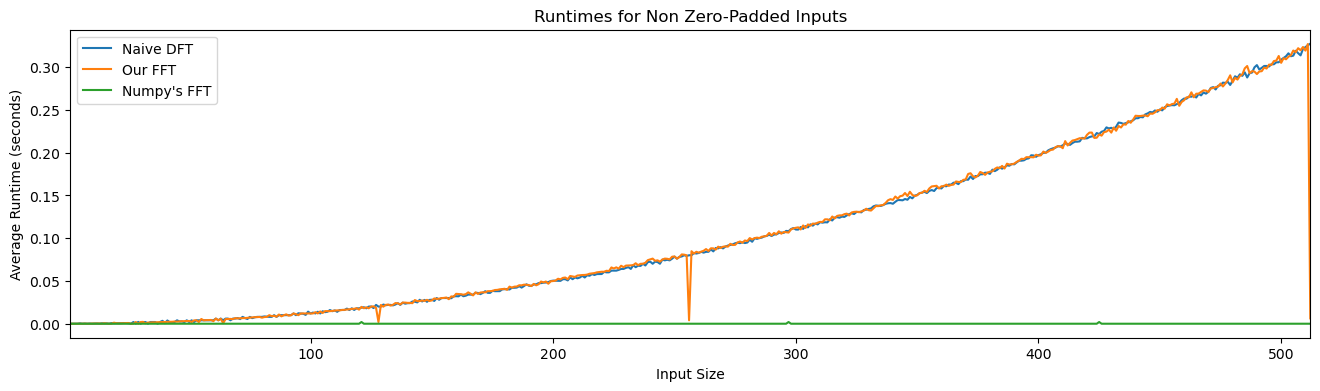

In [10]:
title = "Runtimes for Non Zero-Padded Inputs"
lab3_helper.plot_runtimes(
    INPUT_SIZES, dft_avg_times, my_times_3a, numpy_times_3a, title
)

Note: Numpy's FFT runtimes will look like a flat line at zero. Truly, it is taking some nonzero time to compute, it's just that it's been so insanely optimized that it looks like it runs instantaneously compared to our implementation. This is the main reason why we're only implementing the FFT in this lab to obtain a conceptual understanding of how it works, not to have some tried and true version we'd actually use. In real life, if a library function exists, use it!

**Q: You should see the "Naive DFT" time and "Our FFT" times more or less overlapping, with a few distinct spikes where "Our FFT" does really well. Explain why the graph looks like this, and why the downward spikes occur where they do.**

<span style="color:blue">A:</span> For the majority of size, Our FFT actually call the naive DFT. Only when the size is a power of 2 can it behave like a really FFT.

## Q3b: Performance With Zero-Padding

Run the cells below to profile your FFT function. This time we'll pad everything to the next power of 2. 
This should not take very long to run; the staff version took under 30 seconds on a 2015 laptop.

In [11]:
my_times_3b = lab3_helper.get_avg_runtimes(
    my_fft, INPUT_SIZES, NUM_TRIALS, zero_pad=True
)
numpy_times_3b = lab3_helper.get_avg_runtimes(
    np.fft.fft, INPUT_SIZES, NUM_TRIALS, zero_pad=True
)

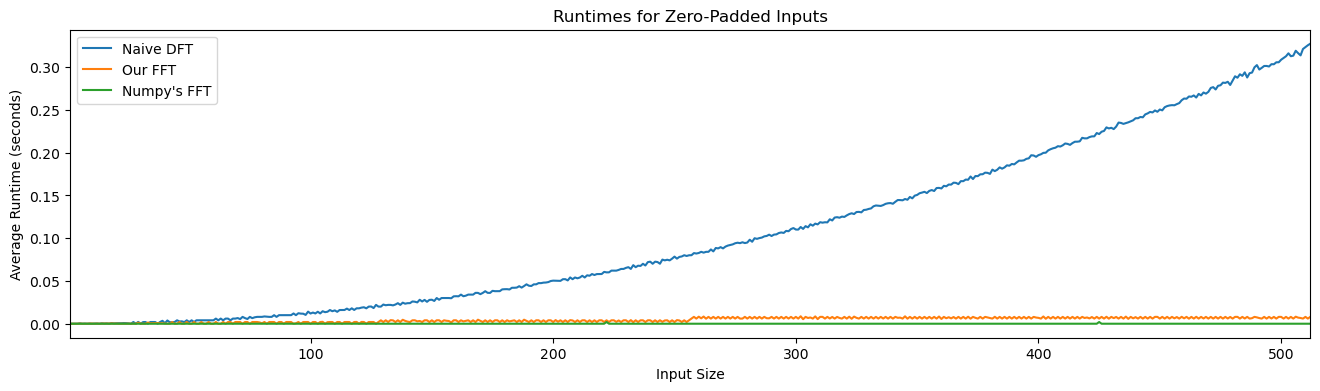

In [12]:
title = "Runtimes for Zero-Padded Inputs"
lab3_helper.plot_runtimes(
    INPUT_SIZES, dft_avg_times, my_times_3b, numpy_times_3b, title
)

**Q: Now, we seem to be doing a lot better. Why does zero-padding help?**

<span style="color:blue">A:</span> Because Our FFT can behave like a really FFT only when the size is a power of 2, and zero-padding achieves this.

**Q: The "Our FFT" plot should look piecewise constant. It's still asymptotically upper bounded by $N \log N$, but why is it piecewise constant rather than some scaled version of the function $N \log N$?** (Hint: Are the runtimes for inputs of size 255 and 256 the same? Why or why not? What about all inputs in the range 129, 130, 131, ..., 256?)

<span style="color:blue">A:</span> Thanks to the zero-padding, sizes between $2^{n-1}$ and $2^{n}$ should behave like the $2^n$ one.

## Q3c: Profiling `numpy.fft.fft`

Now that we've played around with our own function, let's do numpy's!

Since numpy's is much faster than our other functions, and it's hard to see the relevant features for small inputs, we'll crank up both the number of trials AND the range of input sizes here. We'll also use a taller plot.

For Q3c, you just have to run the cells; there's no code to write or conceptual questions to answer. These cells should only take a few seconds to complete.

In [13]:
numpy_inputs = [x for x in range(1, 1025)]
numpy_times = lab3_helper.get_avg_runtimes(
    np.fft.fft, numpy_inputs, num_trials=100, zero_pad=False
)

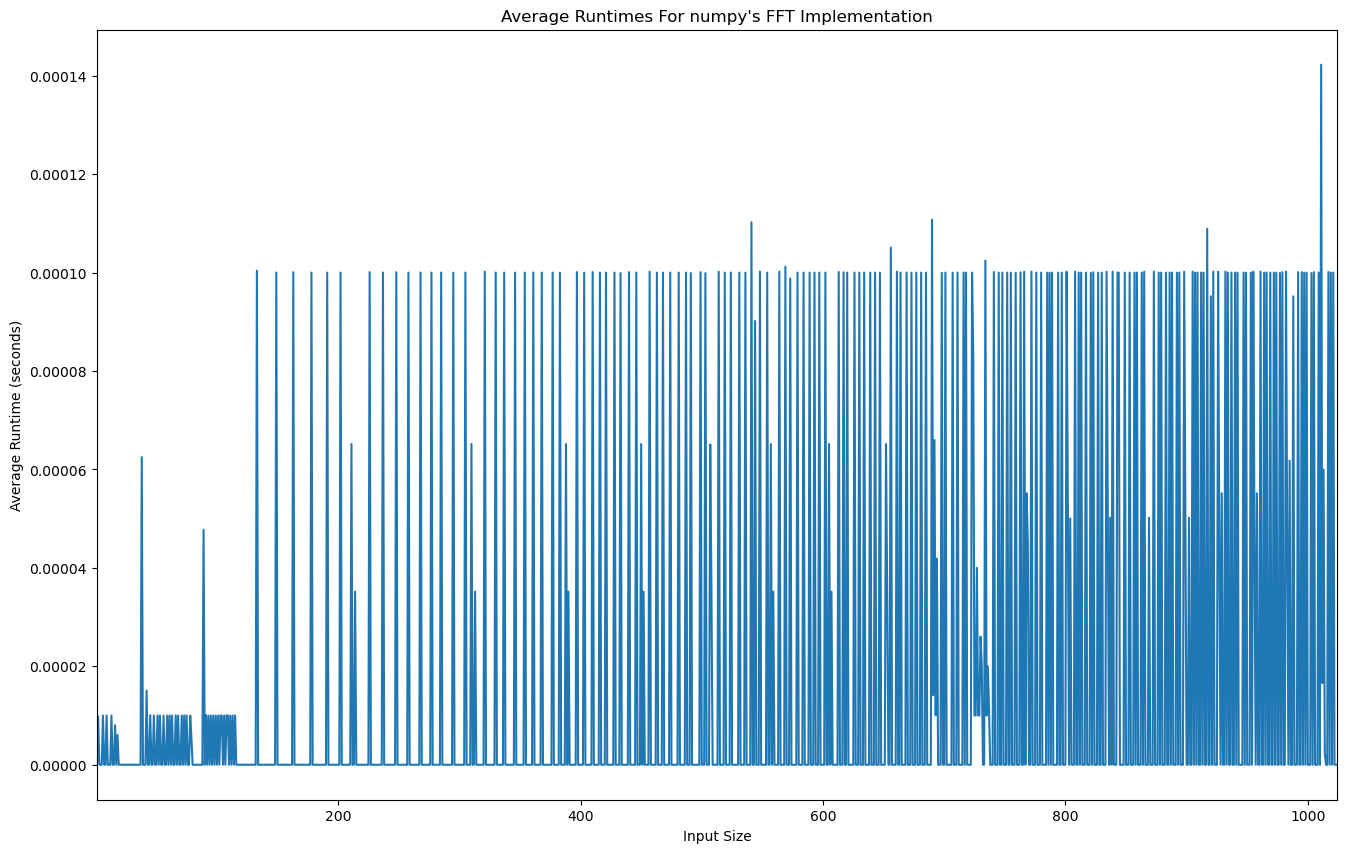

In [14]:
title = "Average Runtimes For numpy's FFT Implementation"
lab3_helper.plot_runtimes_2(numpy_inputs, numpy_times, title)

### What's up with the graph above?
- As discussed above, `numpy.fft.fft` uses a *mixed-radix* approach, combining FFT implementations specialized for powers of different integers so that it can efficiently compute the DFT of inputs of various lengths, not just powers of 2.
- This mixed radix approach is a large reason for these spikes:
    - The minima correspond to powers of 2 or 3, as these are easily handled by radix-2 and radix-3 algorithms. 
    - The maxima correspond to prime numbers. For example, 599, 601, and 607 are all prime numbers; it's hard to make out the exact x-axis values, but we can certainly see some peaks around 600. There's no way to decompose these into smaller primes that we have fixed-radix (e.g. radix-2, radix-3) algorithms to help with.
- You'll also see that the actual time in seconds this function takes is very low compared to some of the numbers we were looking at earlier. In addition to the mixed-radix approach, `numpy.fft.fft`'s parent library is FFTW, Fastest Fourier Transform in the West, a FORTRAN and C based numerical library that's been around since the 1970s, with every performance optimization trick you can imagine (and then some) baked in.

# Q4: Efficient Oscilloscope Calibration

Chances are, you'll never have to re-implement the FFT. However, it's highly likely you'll have to use it as a building block when developing some other efficient algorithm, signals and systems related or otherwise. And that's exactly what we'll do in this question. Specifically, we'll be implementing [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation), and make use of it for calibrating measured signals. 

In scientific experiments as well as testing of any equipment where electronic signals are involved, an *oscilloscope* is the tool of choice for measuring these signals. You've worked with one already in the EE 16B labs, and chances are it looked something like this one from [Tektronix's website](https://www.tek.com/oscilloscope/tbs1000-digital-storage-oscilloscope):

<img src="./scope.jpg" alt="drawing" style="width:400px;"/>

Take a look at the row of five metallic ports on the bottom right - the first four are inputs for a separate *channel* of the scope, enabling multiple measurements at once. On the scope's display, there's three signals: one in yellow, one in blue, and one in purple, each representing a measurement from a separate channel (although no wires are shown going into the ports in the image).

In some setups, multiple channels will be used to measure the same signal for various reasons. However, each channel may have different delays relative to some reference channel, which can cause major issues when analyzing experimental data. For example, if you want to average your channel 1 and channel 2 measurements, but one is delayed from the other by 100 samples, your result may be nonsensical. Here, we'll develop an efficient method for identifying the number of samples one signal lags behind another by, and correct it by shifting the signals so they're aligned properly.

## Q4a: The Gaussian Pulse

One of the most common signals in optics and optical engineering is the *Gaussian pulse*, which is used to model the intensity of light passing through a cross-section of some material as time passes. This is the classic bell-curve shape, except rather than being a probability distribution, here we're just treating it as a normal signal with an amplitude that varies with time. Due to its ubiquity in optics, the Gaussian is a great choice for a signal to develop our algorithm on.

### Full Width at Half Maximum

A very popular quantity used in characterizing the shape of symmetric pulses (including Gaussians, but also others, such as triangular pulses, or Lorentzian pulses) is the Full Width at Half Maximum, or FWHM for short. It is what it sounds like: the width of the pulse at half its max amplitude. 

Here's a visual example of the FWHM of a Gaussian pulse (image credit goes to [6]):

<img src="./FWHM.png" alt="drawing" style="width:400px;"/>

If you've taken a class on probability theory, you've seen the functional form of the Gaussian written as:

$$f(t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-(t - \mu)^2 / 2\sigma^2}$$

This expression parameterized the Gaussian in terms of its *standard deviation*, $\sigma$. While this formulation is useful when considering the Gaussian as a probability density function, the FWHM is far more useful when considering it as a signal. 

Fortunately, there's a way to express the Gaussian in terms of its FWHM instead:

$$f(t) = 2^{-\left(\frac{t}{FWHM / 2}\right)^2}$$

Using this formula, implement `gaussian_pulse` below to generate a gaussian pulse with the middle sample representing time zero.

**Hint:** We want *t* to be an entire range of `L` values, with the middle one being zero. A great trick for doing this in numpy is `np.arange(-L // 2, L // 2)`. The integer division with `//` makes sure we get exactly `L` values. If you're not convinced this works, try working it out on your own when `L` is odd versus even.

In [15]:
def gaussian_pulse(L, fwhm):
    """Returns a gaussian pulse that is L samples long with full width at half maximum of fwhm."""
    # TODO your code here - only return the signal!
    t = np.arange(-L // 2, L // 2)
    div = fwhm / 2
    exp = (t / div) ** 2
    f = 2 ** (-exp)
    return f

Now, check your code by running the cell below. We'll add grid lines with `plt.grid` so it's easier to inspect. Additionally, the formula ensures that the maximum is always 1 (at $t=0$), so half the maximum will always be .5. We've drawn a dashed line to help you identify where to look. Do the visuals match what you expect?

**Hint:** All pulses should be centered at the middle of the plot, with a maximum value of 1. As for the FWHMs, the grid lines are your friend.

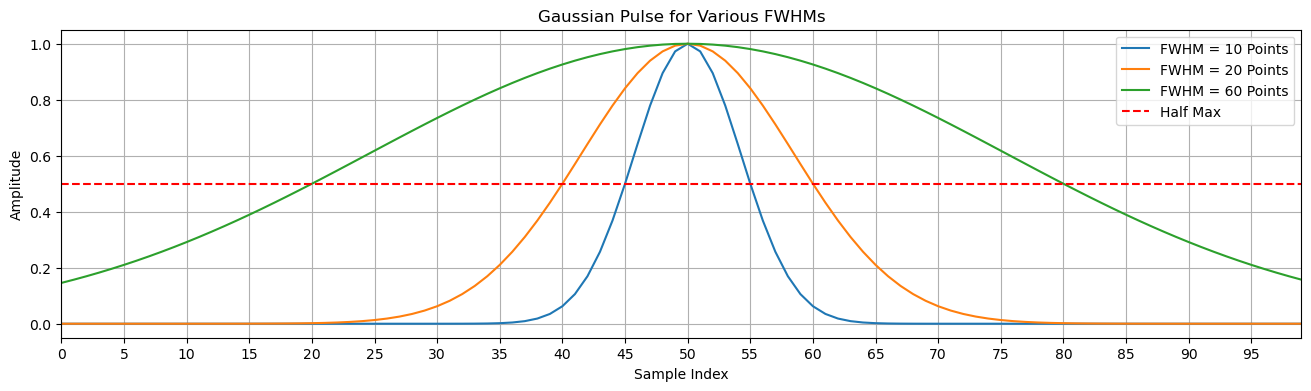

In [16]:
L = 100
FWHMs = [10, 20, 60]
plt.figure(figsize=(16, 4))
for fwhm in FWHMs:
    plt.plot(gaussian_pulse(L, fwhm))
plt.xlim([0, L - 1])
plt.plot(0.5 * np.ones(L), "r--")
plt.legend(["FWHM = {0} Points".format(fwhm) for fwhm in FWHMs] + ["Half Max"])
plt.title("Gaussian Pulse for Various FWHMs")
plt.ylabel("Amplitude")
plt.xlabel("Sample Index")
plt.xticks(np.arange(0, 100, 5))
plt.grid()
plt.show()

## System Model

As is typical for modelling oscilloscopes, we'll assume each channel has its own separate delay and noise level. In practice, this results from the fact that the cables going to each channel have different physical properties. For example, different delays result from different wire lengths. If one wire is shorter than another, the signal travels less distance, and thus arrives earlier in time. Additionally, different noise levels can be caused anything from one cable being more worn out to the other to things as subtle as [small differences in temperature](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise).

We'll consider the case of two channels, although the same principles apply if you had 3-4 or more channels and wanted to calibrate all of them relative to a reference. In all cases, we'll call channel 1 our reference, so that channel 1 is "delay-free" and channel 2 has some delay relative to channel 1.

### Block Diagram

Here's a block diagram representation of the model we'll use:

<img src="./scope_model.png" alt="drawing" style="width:600px;"/>

In reality, $x$ and the delay $d$ would be in continuous time, with the delay being in seconds rather than samples.  The delay in samples would depend on the scope's sampling rate. In the post-processing setup, however, we only have the raw data to deal with, and the method should still work regardless of sampling rate (which we may have no knowledge of), so it's more convenient to model the delay as discrete, and we lose no information in doing so.

In the diagram above,
- We have a $d$-sample delay, expressed by the $z^{-d}$ block. **Note that $d$ could be less than zero, in which case channel 2's signal arrives before channel 1's.**
- Channel 1 measures $y_1[n] = x[n] + z_1[n]$.
- Channel 2 measures $y_2[n] = x[n - d] + z_2[n]$, where $d$ is the number of samples channel 2 lags behind channel 1 by.
- $z_1, z_2$ are additive noise corrupting our signals, whose strengths are determined by the noise levels of each channel. We'll assume channel 2's noise is stronger than channel 1's. Specifically, we'll assume *Additive White Gaussian Noise* (AWGN), one of the most common noise models used in signals and systems.

Our goal is to find $d$, and shift $y_2$ to the left by $d$ samples in post-processing (i.e. on a computer) so that our measurements are properly aligned. We've provided the class `Oscilloscope` for you below, which models this system. You don't have to understand it; all code involving it will be provided to you.

In [17]:
class Oscilloscope:
    """
    Oscilloscope modeled as a set of channels, each of which has its own delay and noise level.
    All noise is modeled as Additive White Gaussian Noise (AWGN), and delays as shifts to the right.
    """

    def __init__(self, num_channels, channel_noise_levels, channel_delays):
        """
        Parameters:
        num_channels         - The number of oscilloscope channels.
        channel_noise_levels - The standard deviation of the AWGN on each channel.
        channel_delays       - The delays, in samples, for each channel.

        A Value_Error is raised if num_channels does not match the number of elements of
        channel_noise_levels and channel_delays, or if all entries of channel_delays are
        not integers.
        """
        channel_delays = np.array(channel_delays)
        if not num_channels == len(channel_noise_levels):
            raise ValueError(
                "Number of channels must match number of noise levels provided."
            )
        if not num_channels == len(channel_delays):
            raise ValueError("Number of channels must match number of delays provided.")
        if not np.array_equal(channel_delays, channel_delays.astype("int")):
            raise ValueError("All delays must be integer-valued.")
        self.num_channels = num_channels
        self.channel_noise_levels = channel_noise_levels
        self.channel_delays = channel_delays

    def measure(self, signal):
        measurements = []
        for i in range(self.num_channels):
            curr_noise = np.random.normal(
                scale=self.channel_noise_levels[i], size=np.shape(signal)
            )
            curr_channel_measurement = (
                np.roll(signal, self.channel_delays[i]) + curr_noise
            )
            measurements.append(curr_channel_measurement)
        return measurements

The cell below simulates the measurement of a Gaussian pulse with a two-channel oscilloscope. If you've never used Python objects before, the code below should give you some feel for how we'll use the `Oscilloscope` class.

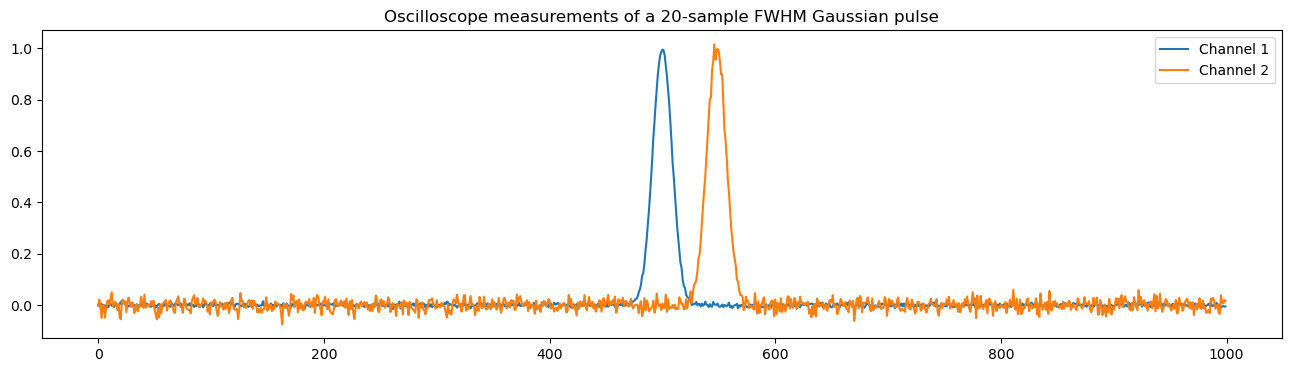

In [18]:
# Measure a 20-sample FWHM gaussian pulse
noise_levels = [0.005, 0.02]
delays = [0, 48]
num_channels = 2
# Construct oscilloscope object
scope = Oscilloscope(num_channels, noise_levels, delays)
# Construct signal to measure
signal = gaussian_pulse(1000, 20)
# Call the "measure" method to simulate the measurement process
measured_signals = scope.measure(signal)

# Display results
plt.figure(figsize=(16, 4))
plt.title("Oscilloscope measurements of a 20-sample FWHM Gaussian pulse")
plt.plot(measured_signals[0], label="Channel 1")
plt.plot(measured_signals[1], label="Channel 2")
plt.legend()
plt.show()

You should see two Gaussian pulses, each noised, with a 20-sample offset between them. This is what our raw data would look like in a real world setup! Our goal is to align these pulses.

## Cross-correlation for offset detection

Now that we're acquainted with our problem setup, we need a way to solve it. Fortunately, there's an incredibly robust method for doing so which you're already acquainted with from EE 16A: cross-correlation. We'll briefly review it in the context of EE 120 before implementing it, however. 

### An EE 120 view of cross-correlation

The cross-correlation of two signals $x$ and $y$, typically denoted as $R_{xy}$ in the signal processing literature, is defined as

$$R_{xy}[n] = \sum_{k=-\infty}^{\infty} x[k+n]y[k]$$

Note that 

$$R_{xy}[n] = \sum_{k=-\infty}^{\infty} y[k]x[n + k] = \sum_{k=-\infty}^{\infty} y[-k]x[n - k]$$

which is the convolution of $x$ and a flipped version of $y$. 

In fact, this is known as a *matched filter*, which is ubiquitous in radar and digital communication applications for detection of a known signal. In such applications, $y$ would represent some a priori known signal, such as a fixed preamble to identify where a message starts, and $x$ would be a noisy, measured signal. The matched filer would identify where the preamble $y$ lies within $x$ to determine where the message begins. Similarly, we want to know where our Channel 2 measurement lies within our Channel 1 measurement here to determine the offset.

### Viewing signals as vectors for measuring similarity 

To make this idea of cross-correlation as a measure of similarity more concrete, consider the normalized cross-correlation, which we'll denote as $\tilde{R}_{xy}$:

$$\tilde{R}_{xy}[n] = \dfrac{\sum_{k=-\infty}^{\infty} x[k+n]y[k]}{\left(\sqrt{\sum_{k=-\infty}^{\infty} |x[k]|^2}\right) \left(\sqrt{\sum_{k=-\infty}^{\infty} |y[k]|^2}\right)}$$

The only difference here is that we divide by the square roots of the signals' energies, which ensures the result is always between -1 and 1, analogous to the correlation coefficient in statistics. 

In the context of finite-duration signals (say, of length $N$), which we deal with on computers, the signals can be viewed as vectors in $\mathbb{R}^N$, and this just corresponds to dividing by the signals' vector norms. This vector interpretation is where the idea of cross-correlation as a similarity measure comes into play. Recall that if the angle between two vectors $\vec{x}, \vec{y}$ is $\theta$, then

$$\cos(\theta) = \dfrac{\vec{x} \cdot \vec{y}}{||\vec{x}|| \cdot ||\vec{y}||}$$

and thus $\tilde{R}_{xy}[n]$ is precisely the cosine of the angle between $x[n+k]$ and $y[k]$, if you consider them restricted to a finite duration, as we have here. 

Recall $-1 \leq \cos(\theta) \leq 1$, as we said above for our normalized cross-correlation. Additionally, the maximum of $\cos(\theta)$ is achieved when $\theta = 0$ if we restrict $\theta \in [0, 2\pi)$.

So:
- The larger the normalized cross-correlation $\tilde{R}_{xy}[n]$ is, the larger $\cos(\theta)$ is, since they're equal. Here, $\theta$ is the angle between the two signals $x, y$ when considered as vectors in the $N$-dimensional Euclidean space.
- The larger $\cos(\theta)$ is, the closer $\theta$ is to 0.
- As $\theta$ goes to 0 (i.e., the cross-correlation increases), the signals are more and more aligned in $\mathbb{R}^N$ since the angle between them is smaller. Thus, a higher value in the cross-correlation for a given offset corresponds to the signals being more similar in a precise geometric sense!

**The takeaway from all this is that if we compute the cross-correlation of two vectors, the lag factor where it's maximized is the delay by which the signals are most similar. As a result, to find the offset between two signals, we should simply compute their cross-correlation, and return the index at which it's maximized!**

## Q4b: Cross-correlating

Implement the function `xcorr` which returns the **normalized** cross-correlation of two signals $x$ and $y$. To ensure an efficient implementation, you should use the FFT. Feel free to make use of numpy's implementation; specifically, these functions will be of use:
- [np.fft.fft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html)
- [np.fft.ifft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifft.html)
- [np.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)

You may **NOT** use `np.convolve`, `np.correlate`, or any other library functions that directly compute convolution or cross-correlation, in your implementation.

### Multiplying DFTs versus DTFTs; Zero-padding

One of the oddities of computing convolutions (or, in our case, cross-correlations) via the FFT is that multiplying two DFTs corresponds to *circular* convolution (or cross-correlation) in time, not linear convolution (or cross-correlation). Multiplication of DTFTs corresponds to linear convolution, and multiplication of two DTFTs after first flipping the appropriate time-domain signal to cross-correlation.

Fortunately, there's an easy workaround to compute a linear convolution (or cross-correlation) using the DFT: if $x$ is length $N$ and $y$ is length $M$, zero-pad $x$ and $y$ to both be of length $M+N-1$ and then just compute their linear convolution (or cross-correlation) by multiplying their DFTs (if computing the cross-correlation $R_{xy}$, $y$ should also first be flipped). A full explanation of why this works can be found in [8]. 

After doing this padding, in order to further maximize efficiency, we may as well pad all the way out to the next power of 2 after $M+N-1$. Feel free to use the function `next_power_of_2` in doing so. This won't affect our cross-correlation results, since we're just adding in extra terms to these shifted dot products that multiply by zeros. Here, your friends will be [np.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) and [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html).

### Centering the cross-correlation

By default, the first value of our cross-correlation is the dot product between $x[n]$ and $y[n]$, then the first half of the cross-correlation will be for shifts of $1, 2, 3,..., N/2$ (where $N$ is the length we pad to), followed by shifts of $-1, -2, -3, ..., -N/2$. It's much easier to work with the result of a cross-correlation, as well as visualize and understand the plot of it, known as a *correlogram*, when the middle corresponds to a zero offset. To do so, we need to circularly shift the result by half its length, which the function [np.fft.fftshift](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html) does. Feel free to use it by calling it after computing your cross-correlation. This is analogous to adopting the convention of plotting DTFTs from $-\pi$ to $\pi$ instead of $0$ to $2\pi$, which is actually the original reason `fftshift` was created as a library routine.

### Numerical precision issues

Finally: before returning your zero-delay centered cross-correlation, call [np.real](https://docs.scipy.org/doc/numpy/reference/generated/numpy.real.html) on it. The reason is that due to limited numerical precision, after calling `ifft`, your time-domain result will have small (~$10^{-10}$) imaginary components which aren't truly part of the result (the cross-correlation of two real-valued signals is always real-valued). Calling this function discards them. This function, as a result, is only built to handle real signals. All signals measured on an oscilloscope in practice will be real, so this is fine.

**Hint:** If we wanted to implement the convolution of two signals via the FFT, we could just multiply their FFTs, since convolution in time is multiplication in frequency. Here, we have a similar, but not entirely identical situation when computing the cross-correlation, since one signal is flipped. What does flipping a **real-valued** (since all oscilloscope data will be real) signal in time do to its spectrum? Is there a convenient numpy function for doing this?

## Cross-Correlation Algorithm Summary

That was a lot of reading! Here's an executive summary if you're a bit overwhelmed:
1. Compute $L$, the next power of two after the length of $x$ plus the length of $y$ minus 1.
2. Zero pad $x$ and $y$ to length $L$.
3. Compute the FFTs of the zero-padded $x$ and $y$ signals.
4. Multiply these FFTs, *first* (i.e., before the multiplication) doing the operation on $y$'s FFT that is the frequency-domain equivalent of flipping a real signal. We're being purposely vague about what this operation is so you can figure it out - this is where the DTFT properties matter! You shouldn't need to do any flipping. Remember, it's a *real* signal in the time domain.
5. Take the inverse FFT. Now, we're back in the time domain.
6. Divide by $(||x|| \cdot ||y||)$.
7. Call fftshift.
8. Return the real part.

In [19]:
def next_power_of_2(n):
    """Returns the next power of 2 after and including n."""
    return 2 ** int(np.ceil(np.log2(n)))


def xcorr(x, y):
    """
    Returns the cross-correlation of x and y, padded to the next power of 2 after len(x) + len(y) - 1.
    Assumes that x, y are both real signals.
    """
    # TODO your code here
    n = len(x) + len(y) - 1
    L = next_power_of_2(n)
    x = np.concatenate((x, np.zeros(L - len(x))))
    y = np.concatenate((y, np.zeros(L - len(y))))
    X = np.fft.fft(x)
    Y = np.fft.fft(y)
    XY = X * np.conj(Y)
    xy = np.fft.ifft(XY)
    norm_xy = xy / np.linalg.norm(x) / np.linalg.norm(y)
    result = np.real(np.fft.fftshift(norm_xy))
    return result

Run the cell below to test your `xcorr` function; these tests aren't comprehensive but should be good enough for our purposes. We can't compare directly against `np.correlate` as we did above with our FFT for two reasons:
- We normalize our cross-correlation (numpy's is unnormalized; in fact, if you check out the [source code on GitHub](https://github.com/numpy/numpy/blob/master/numpy/core/numeric.py), you'll see that there's a library routine for cross-correlation and `np.convolve` is implemented by calling it with the second argument flipped).
- We zero-pad our cross-correlation to the next power of two.

If we were writing a real library-grade implementation, we might want to consider these things more carefully (e.g., add options for zero padding or not, as well as whether or not to normalize) but for our purposes, what we have will do just fine.

In [20]:
# Test 1: xcorr([1,2], [1,2])
test1_correct = np.array([0, 0.4, 1, 0.4])
test1_actual = xcorr([1, 2], [1, 2])

# Test 2: xcorr([-1, 0, 1], [-1.5, 0.2, 1.5])
test2_correct = np.array(
    [
        0.00000000e00,
        1.38165169e-17,
        -4.97792484e-01,
        -6.63723312e-02,
        9.95584967e-01,
        6.63723312e-02,
        -4.97792484e-01,
        -1.38165169e-17,
    ]
)
test2_actual = xcorr([-1, 0, 1], [-1.5, 0.2, 1.5])

# Test 3: xcorr([1,1,1,1,1], [1,2,3,2,1])
test3_correct = np.array(
    [
        0.00000000e00,
        -9.11251831e-17,
        -4.55625916e-17,
        -2.27812958e-17,
        1.02597835e-01,
        3.07793506e-01,
        6.15587011e-01,
        8.20782682e-01,
        9.23380517e-01,
        8.20782682e-01,
        6.15587011e-01,
        3.07793506e-01,
        1.02597835e-01,
        -2.27812958e-17,
        -4.55625916e-17,
        -9.11251831e-17,
    ]
)
test3_actual = xcorr([1, 1, 1, 1, 1], [1, 2, 3, 2, 1])

# Test 4: xcorr([1, 1], [3, 6, 9])
test4_correct = np.array([0.56694671, 0.94491118, 0.56694671, 0.18898224])
test4_actual = xcorr([1, 1], [3, 6, 9])

# Test 5: cross-correlation of two gaussian pulses with different FWHMs (should give a Gaussian with a new FWHM)
sig = gaussian_pulse(50, 10)
test5_correct = gaussian_pulse(128, 14.14213)
test5_actual = xcorr(sig, sig)

print("Test 1 (same size) passed: {}".format(np.allclose(test1_correct, test1_actual)))
print("Test 2 (same size) passed: {}".format(np.allclose(test2_correct, test2_actual)))
print("Test 3 (same size) passed: {}".format(np.allclose(test3_correct, test3_actual)))
print(
    "Test 4 (different sizes) passed: {}".format(
        np.allclose(test4_correct, test4_actual)
    )
)
print("Test 5 (same size) passed: {}".format(np.allclose(test5_correct, test5_actual)))

Test 1 (same size) passed: True
Test 2 (same size) passed: True
Test 3 (same size) passed: True
Test 4 (different sizes) passed: True
Test 5 (same size) passed: True


## Q4c: Realignment

Now that we have a means of efficiently computing the cross-correlation of two signals, we can make use of it to find the offset between our signals! Implement `opt_offset` below, which takes in two signals, $x$ and $y$, and returns the optimal offset between them, by returning the delay, in samples, at which their cross-correlation is maximized. The function [np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) will be useful.

**Hint:** Our cross-correlation function is zero-centered. To find the actual delay, we need to extract the index at which the cross-correlation is maximized, and subtract the index corresponding to a zero delay (i.e., the center) from it.

In [21]:
def opt_offset(x, y):
    """Returns the most likely number of samples that x lags behind y via cross-correlation."""
    # TODO your code here
    corr = xcorr(x, y)
    index = np.argmax(corr)
    return index - len(corr) // 2

We'll use a more complete suite of test cases below, but here a few sanity checks on `opt_offset` you can run. If any of them `AssertionError`, that's saying that the test failed. If not, you're in good shape.

In [22]:
# 1st lags behind 2nd by 1 sample
assert opt_offset([0, 0, 1, 0], [0, 1, 0, 0]) == 1
# 1st lags behind 2nd by 2 samples
assert opt_offset([0, 0, 1, 0], [1, 0, 0, 0]) == 2
# 1st is ahead of 2nd by 4 samples (i.e., behind by -4)
assert opt_offset([1, 0, 0, 0, 0], [0, 0, 0, 0, 1]) == -4

To clean everything up into a nice interface, let's write one last function, `align`, which takes in two signals, finds the optimal offset between them, and shifts the first by that amount so they're aligned. This should be very simple once you have `opt_offset` working. We won't tell you what numpy function to use to perform the shifting, but you should be able to find it easily on Google.

**Hint:** After obtaining the optimal offset, you want to shift *backwards* by that amount. For example, consider the first test above. `[0,0,1,0]` lags behind `[0,1,0,0]` by 1 sample since the impulse arrives one sample later in the first signal, so we want to shift it to the *left* by 1 sample. Equivalently, we could shift it to the *right* by -1 sample. Keep this in mind when performing the shift.

In [23]:
def align(x, x_ref):
    """Assuming x is a delayed copy of x_ref, finds the timing offset and shifts x to be aligned with x_ref."""
    # TODO your code here
    offset = opt_offset(x, x_ref)
    return np.roll(x, -offset)

Now we can test our timing calibration method on some real signals! Run the cell below, and see how your results look.

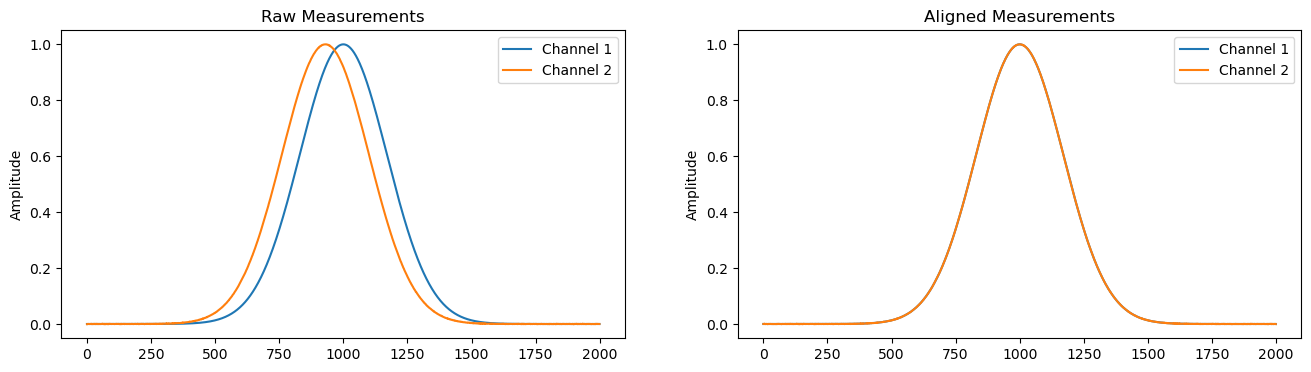

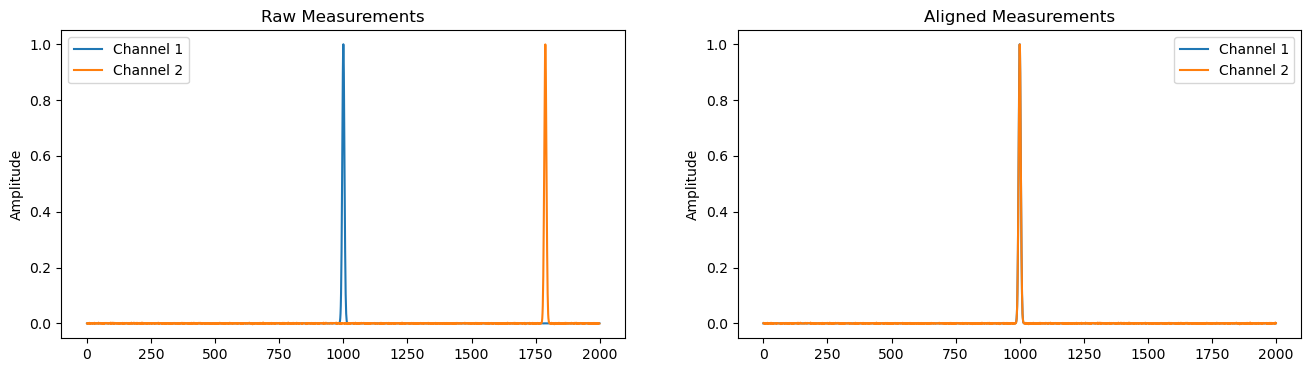

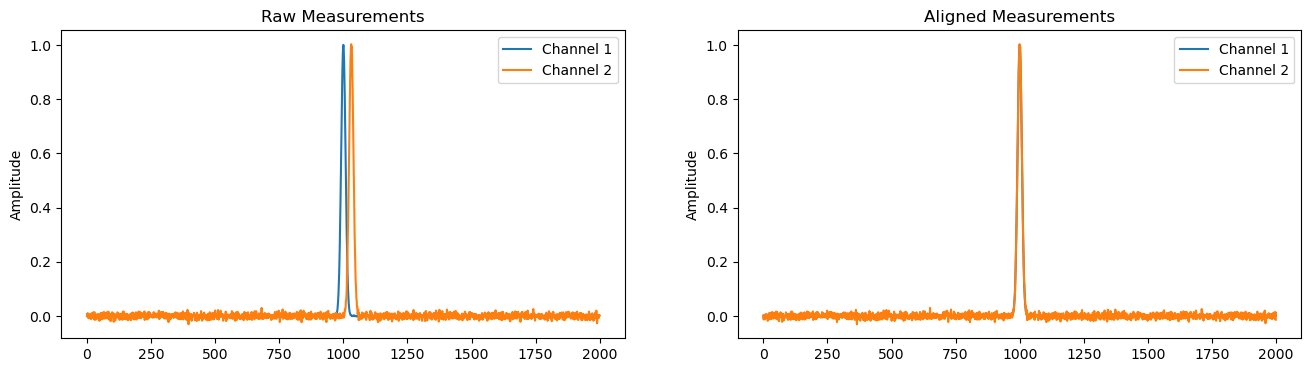

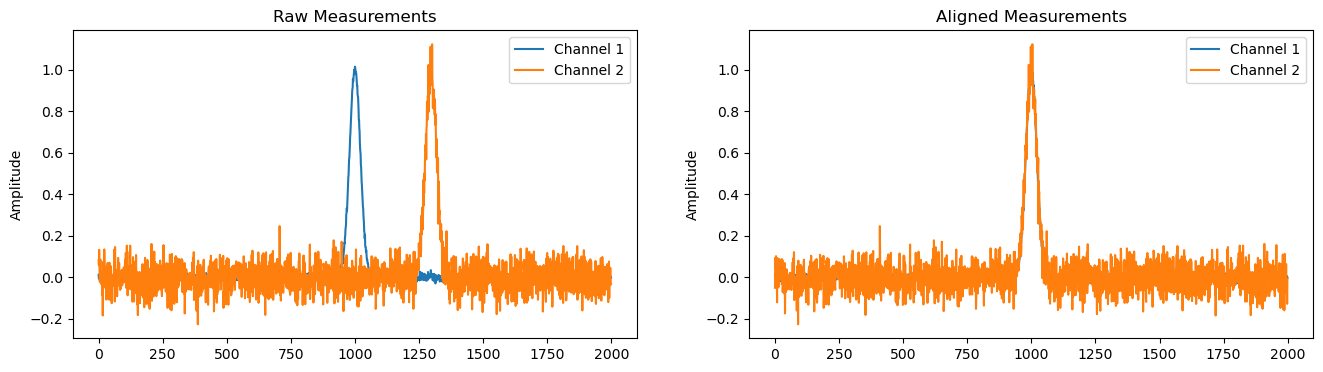

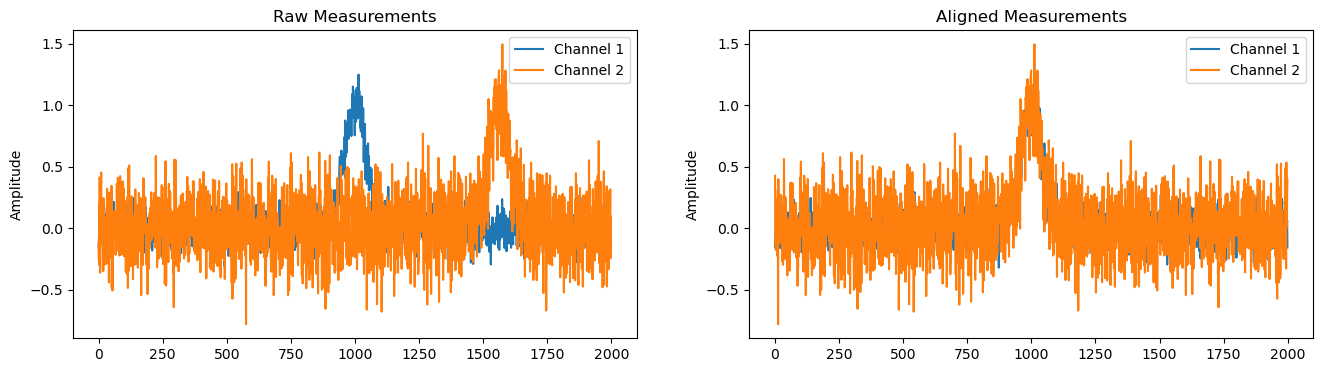

In [24]:
# Mock setup to test out the calibration
num_channels = 2
record_length = 2000
fwhms = [400, 10, 20, 50, 100]
ch1_noise_levels = [0, 0.0001, 0.001, 0.01, 0.1]
ch2_noise_levels = [0.0003, 0.0009, 0.008, 0.06, 0.23]
ch1_delays = [0, 0, 0, 0, 0]
ch2_delays = [-70, 788, 31, 297, 563]


for i in range(len(fwhms)):
    # Construct oscilloscope
    curr_noise_levels = [ch1_noise_levels[i], ch2_noise_levels[i]]
    curr_delays = [ch1_delays[i], ch2_delays[i]]
    scope = Oscilloscope(num_channels, curr_noise_levels, curr_delays)

    # Measure
    curr_signal = gaussian_pulse(record_length, fwhms[i])
    measured_signals = scope.measure(curr_signal)
    ch1_meas = measured_signals[0]
    ch2_meas = measured_signals[1]

    # Align and display results
    ch2_corrected = align(ch2_meas, ch1_meas)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.title("Raw Measurements")
    plt.plot(ch1_meas, label="Channel 1")
    plt.plot(ch2_meas, label="Channel 2")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Aligned Measurements")
    plt.plot(ch1_meas, label="Channel 1")
    plt.plot(ch2_corrected, label="Channel 2")
    plt.ylabel("Amplitude")
    plt.legend()
plt.show()

If done correctly, you should see two columns and five rows. The first column will contain the "raw", unaligned measurements, and the second is the result of calling your `align` function to compensate for the delays. If everything is correct, you should see nicely aligned signals in the second column. 

Take a look at how well your alignment works, even on the bottom row, where the noise is incredibly strong - cross-correlation's offset detection capability in the presence of additive random noise is remarkably robust. (Optional fun experiment: create a new cell below, and, reusing the code above, see how high you can crank up the noise levels before our realignment technique fails. Since the noise is random, you could even re-run the experiment multiple times and empirically find the probability of the procedure failing as a function of the noise standard deviation!)

# References

[1] Video lecture on the FFT. [Link](https://www.youtube.com/watch?v=1mVbZLHLaf0)   
[2] The FFT (Wikipedia). Has a great derivation of the algorithm. [Link](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm)  
[3] Notes from MIT's 6.341 (Discrete-Time Signal Processing) on the FFT. [Link](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-341-discrete-time-signal-processing-fall-2005/lecture-notes/lec19.pdf)  
[4] EE 123 Spring 2018 FFT lecture slides. [Link 1](https://inst.eecs.berkeley.edu/~ee123/sp18/Notes/Lecture3C.pdf), [Link 2](https://inst.eecs.berkeley.edu/~ee123/sp18/Notes/Lecture4A.pdf)  
[5] Modern uses of DFT. [Link](http://news.mit.edu/2009/explained-fourier)  
[6] Full width at half maximum (Wikipedia). [Link](https://en.wikipedia.org/wiki/Full_width_at_half_maximum)  
[7] Matched filtering (Wikipedia). Includes multiple derivations of optimality and some examples. [Link](https://en.wikipedia.org/wiki/Matched_filter)  
[8] EE 123 Spring 2018 DFT and convolution lecture slides. [Link](https://inst.eecs.berkeley.edu/~ee123/sp18/Notes/Lecture3B.pdf)